In [1]:
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt
import torch

from physics_driven_ml.dataset_processing import PDEDataset, BatchedElement
from torch.utils.data import DataLoader

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance
/home/meng-yang/firedrake/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# ... (All your previous code including tensor field function definition)

# Given tensor field data, create scalar functions for the components and magnitude
def create_scalar_functions_from_tensor(tensor_field, mesh):
    components = [(0, 0), (0, 1), (1, 0), (1, 1)]
    scalar_functions = []

    for (i, j) in components:
        scalar_data = tensor_field.dat.data[:, i, j]
        scalar_function = fd.Function(fd.FunctionSpace(mesh, "CG", 1))
        scalar_function.dat.data[:] = scalar_data
        scalar_functions.append(scalar_function)

    magnitude_data = np.sqrt(np.sum(tensor_field.dat.data**2, axis=(1, 2)))
    magnitude_function = fd.Function(fd.FunctionSpace(mesh, "CG", 1))
    magnitude_function.dat.data[:] = magnitude_data

    return scalar_functions, magnitude_function

# Visualize the scalar functions
def visualize_scalar_functions(scalar_functions, magnitude_function):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    titles = ["(0,0) Component", "(0,1) Component", "(1,0) Component", "(1,1) Component"]

    for ax, scalar_fn, title in zip(axs.ravel(), scalar_functions, titles):
        collection = fd.tripcolor(scalar_fn, axes=ax, cmap='coolwarm')
        ax.set_title(title)
        fig.colorbar(collection, ax=ax)

    plt.tight_layout()
    plt.show()

    # Visualize the magnitude
    plt.figure(figsize=(6, 5))
    collection = fd.tripcolor(magnitude_function, cmap='viridis')
    plt.colorbar(collection)
    plt.title("Tensor Magnitude (Frobenius Norm)")
    plt.show()
    
def predict(test_dataloader, model, index):
    # Ensure model is in evaluation mode
    model.eval()
    # Extract stress tensor from the test dataloader at the given index
    strain_tensor = test_dataloader.dataset[index].target
    mesh = fd.UnitSquareMesh(32, 32)
    # Convert to TensorFunctionSpace for visualization
    V_tensor = fd.TensorFunctionSpace(mesh, 'CG', 1)
    strain_function = fd.Function(V_tensor)
    strain_tensor = strain_tensor.reshape(-1, 2, 2)
    strain_function.dat.data[:] = strain_tensor.numpy()
    
    # Visualize the stress tensor fields
    scalar_fns, magnitude_fn = create_scalar_functions_from_tensor(strain_function, mesh)
    print("Visualizing Input Strain Tensor Fields")
    visualize_scalar_functions(scalar_fns, magnitude_fn)
    
    # Predict strain using the model
    with torch.no_grad():
        strain_tensor = strain_tensor.unsqueeze(0).to(torch.float32)  # Adding batch dimension
        predicted_stress_tensor = model(strain_tensor).squeeze(0)  # Removing batch dimension
    
    # Convert predicted stress tensor to TensorFunctionSpace for visualization
    predicted_stress_function = fd.Function(V_tensor)
    predicted_stress_tensor = predicted_stress_tensor.reshape(-1, 2, 2)
    predicted_stress_function.dat.data[:] = predicted_stress_tensor.numpy()
    
    # Visualize the predicted stress tensor fields
    scalar_fns_pred, magnitude_fn_pred = create_scalar_functions_from_tensor(predicted_stress_function, mesh)
    print("Visualizing Predicted Stress Tensor Fields")
    visualize_scalar_functions(scalar_fns_pred, magnitude_fn_pred)
    
    # Visualize real stress for comparison
    real_stress_tensor = test_dataloader.dataset[index].u_real
    real_stress_function = fd.Function(V_tensor)
    real_stress_tensor = real_stress_tensor.reshape(-1, 2, 2)
    print('real stress tensor ',real_stress_tensor.shape)
    real_stress_function.dat.data[:] = real_stress_tensor.numpy()
    
    scalar_fns_real, magnitude_fn_real = create_scalar_functions_from_tensor(real_stress_function, mesh)
    print("Visualizing Real Strain Tensor Fields")
    visualize_scalar_functions(scalar_fns_real, magnitude_fn_real)




Visualizing Input Stress Tensor Fields


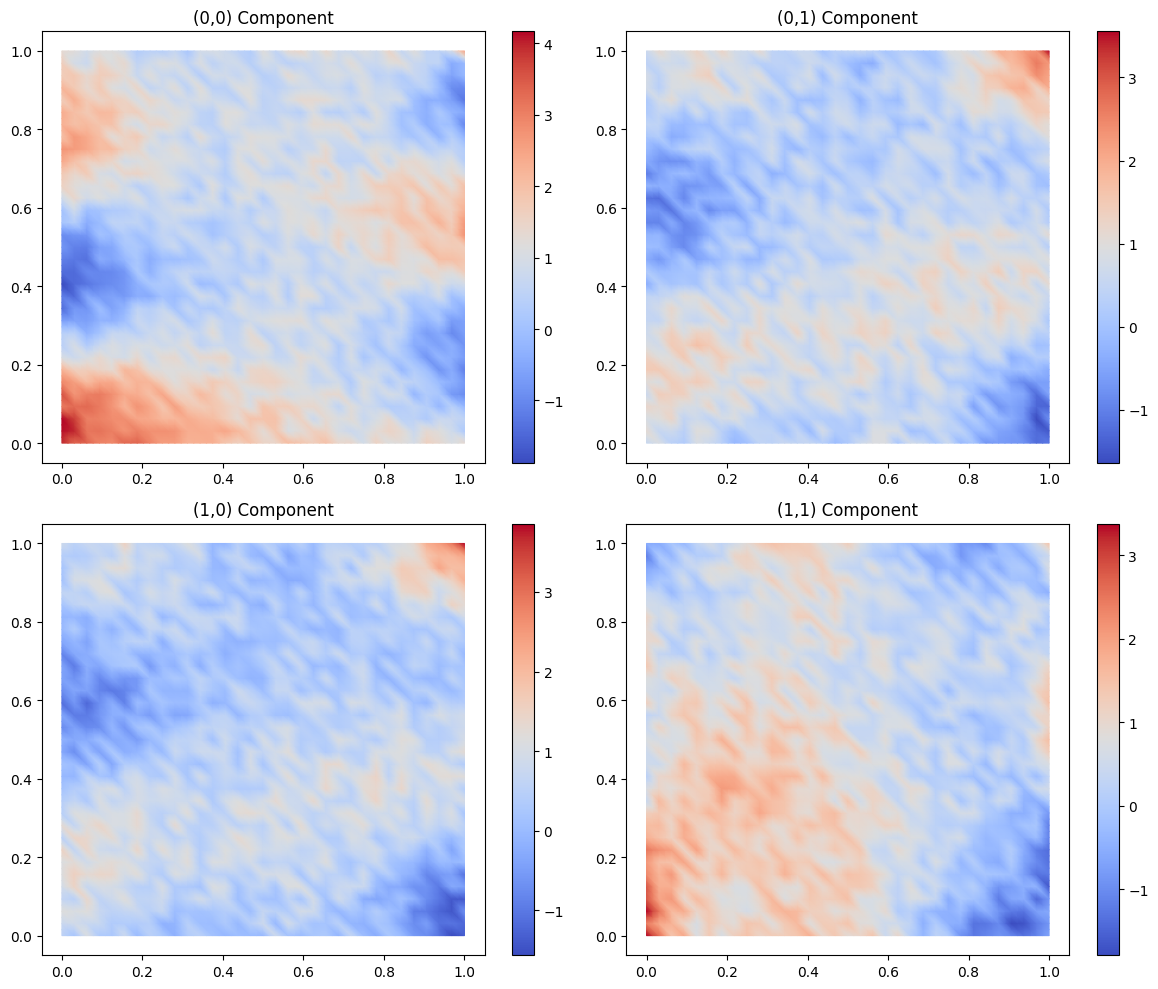

<Figure size 600x500 with 0 Axes>

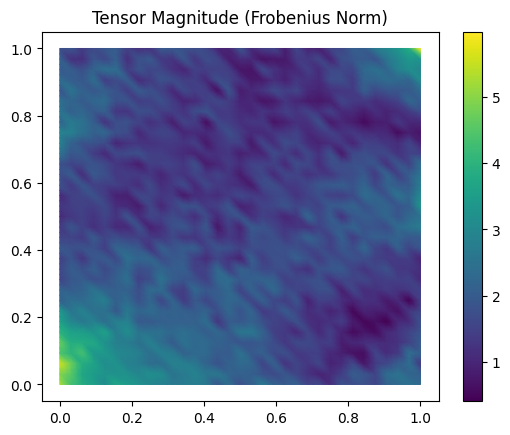

Visualizing Predicted Strain Tensor Fields


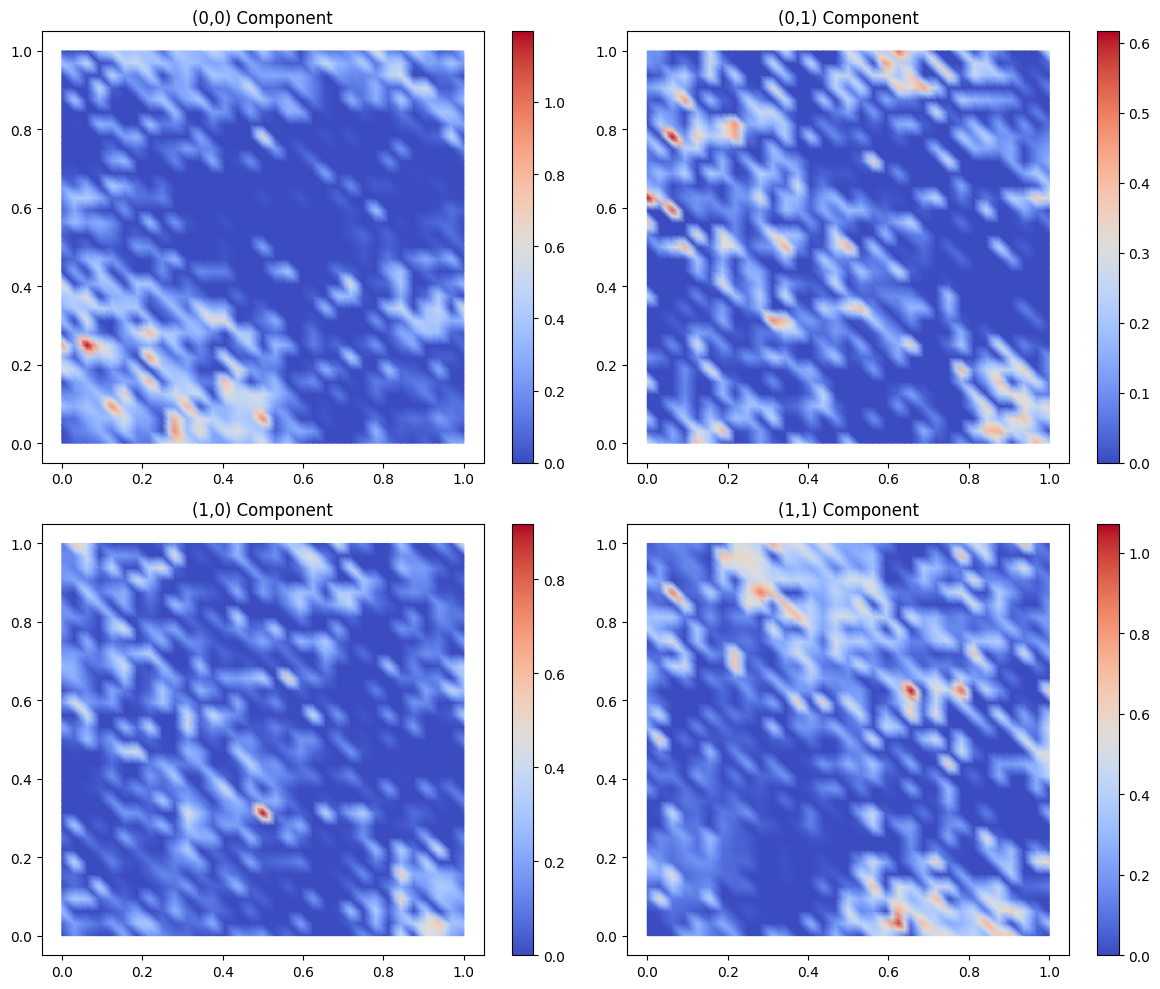

<Figure size 600x500 with 0 Axes>

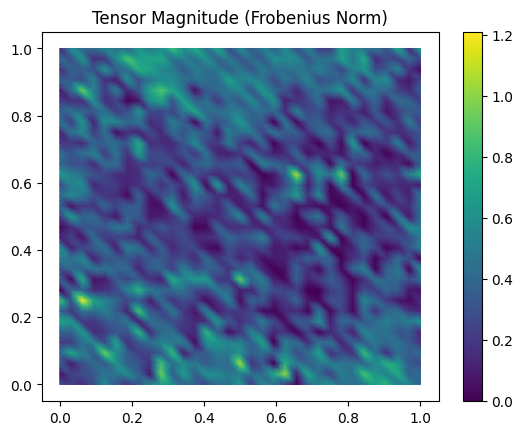

real strain tensor  torch.Size([1089, 2, 2])
Visualizing Real Strain Tensor Fields


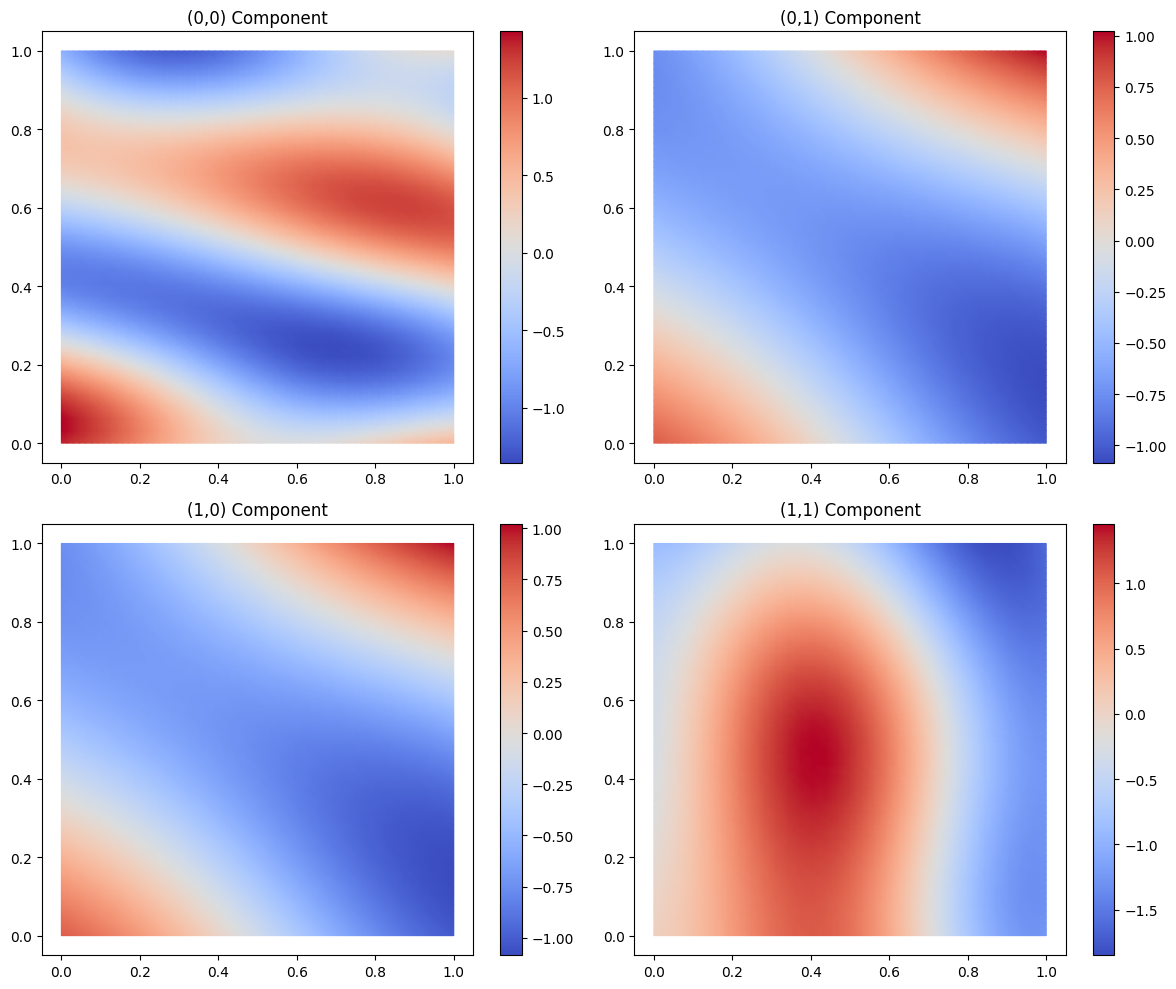

<Figure size 600x500 with 0 Axes>

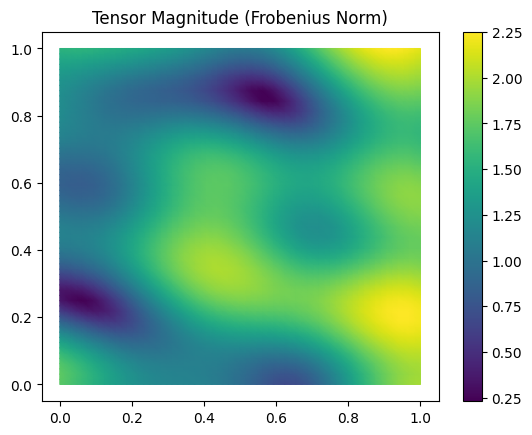

In [4]:
test_dataset = PDEDataset(dataset="linear_elasticity", dataset_split="test", data_dir="data")
test_dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=test_dataset.collate, shuffle=False)

from physics_driven_ml.models import CNN
model = CNN.from_pretrained(model_dir='saved_models/linear_elasticity')
# Test the predict function
predict(test_dataloader, model, index=  1)  # Example with index 0